# Predict Success of Youtuber Influences
## Part 2: Evaluation of Variables
#### 11/20/2017, Julianne Freeman

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%load_ext version_information
%version_information numpy, scipy, matplotlib, pandas

Software versions
Python 3.6.0 64bit [GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)]
IPython 5.1.0
OS Darwin 16.1.0 x86_64 i386 64bit
numpy 1.11.3
scipy 0.18.1
matplotlib 2.0.0
pandas 0.19.2
Wed Nov 22 20:20:09 2017 EST

In [142]:
from __future__ import division
from datetime import datetime 
import requests
from lxml import html, etree
import json
from textblob import TextBlob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from collections import Counter

#never print matching warnings
warnings.filterwarnings('ignore') 

#set how pandas displays data
pd.options.display.max_columns = 100
pd.options.display.max_rows = 35
pd.options.display.width = 120

#change the max # of rows pandas will display
pd.options.display.max_rows = 4000

#set to display all output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#import seaborn to draw pretty graphs
import seaborn as sns
sns.set_style('whitegrid')

# Step 1: Load data

In [8]:
data=pd.read_csv('Youtube_Project_20171121.csv')
data.head(2)

Unnamed: 0  Unnamed: 0.1  commentCount  dislikeCount  favoriteCount  likeCount  viewCount     video_id  \
0           0             0         739.0         191.0              0    11178.0   274412.0  zfmi2JatvlY   
1           1             1        1010.0         224.0              0    11737.0   319477.0  XlawoU0xCwQ   

           publishedAt                 date  week                 channelId  \
0  2016-06-24 23:22:46  2016-06-24 00:00:00    25  UCDHQbU57NZilrhbuZNbQcRA   
1  2016-06-23 02:46:20  2016-06-23 00:00:00    25  UCDHQbU57NZilrhbuZNbQcRA   

                                        title                                        description   channelTitle  \
0     WHAT'S IN MY TRAVEL BAG | PatrickStarrr  Hey everyone! I've been traveling a lot lately...  PatrickStarrr   
1  I AM A GEISHA | JAPAN VLOG | PatrickStarrr  Discount on TATCHA use code "PSTARRR" \nHuge t...  PatrickStarrr   

   categoryId key_word    type  duration  hours  minutes  seconds  total_mins  total_secs  year  month  yearmonth  \
0          26      NaN  beauty     PT15M      0       15        0          15         900  2016      6     201606   
1          26      NaN  beauty  PT28M32S      0       28       32          28        1712  2016      6     201606   

      vlog  title_length  description_length title_channel month_name  season day_of_week type_of_day series  
0  notvlog            39                1516   includes_CT       June  summer         Fri     weekday     no  
1     vlog            42                1595   includes_CT       June  summer       Thurs     weekday     no

In [11]:
del data['Unnamed: 0']
del data['Unnamed: 0.1']
data.head(2)

commentCount  dislikeCount  favoriteCount  likeCount  viewCount     video_id          publishedAt  \
0         739.0         191.0              0    11178.0   274412.0  zfmi2JatvlY  2016-06-24 23:22:46   
1        1010.0         224.0              0    11737.0   319477.0  XlawoU0xCwQ  2016-06-23 02:46:20   

                  date  week                 channelId                                       title  \
0  2016-06-24 00:00:00    25  UCDHQbU57NZilrhbuZNbQcRA     WHAT'S IN MY TRAVEL BAG | PatrickStarrr   
1  2016-06-23 00:00:00    25  UCDHQbU57NZilrhbuZNbQcRA  I AM A GEISHA | JAPAN VLOG | PatrickStarrr   

                                         description   channelTitle  categoryId key_word    type  duration  hours  \
0  Hey everyone! I've been traveling a lot lately...  PatrickStarrr          26      NaN  beauty     PT15M      0   
1  Discount on TATCHA use code "PSTARRR" \nHuge t...  PatrickStarrr          26      NaN  beauty  PT28M32S      0   

   minutes  seconds  total_mins  total_secs  year  month  yearmonth     vlog  title_length  description_length  \
0       15        0          15         900  2016      6     201606  notvlog            39                1516   
1       28       32          28        1712  2016      6     201606     vlog            42                1595   

  title_channel month_name  season day_of_week type_of_day series  
0   includes_CT       June  summer         Fri     weekday     no  
1   includes_CT       June  summer       Thurs     weekday     no

In [12]:
#determine number of rows in data
data.shape[0]

11509

In [36]:
#view data types
data.dtypes

commentCount          float64
dislikeCount          float64
favoriteCount           int64
likeCount             float64
viewCount             float64
video_id               object
publishedAt            object
date                   object
week                    int64
channelId              object
title                  object
description            object
channelTitle           object
categoryId              int64
key_word               object
type                   object
duration               object
hours                   int64
minutes                 int64
seconds                 int64
total_mins              int64
total_secs              int64
year                    int64
month                   int64
yearmonth               int64
vlog                   object
title_length            int64
description_length      int64
title_channel          object
month_name             object
season                 object
day_of_week            object
type_of_day            object
series    

# Step 2: Check dependent variable

### Variable: viewCount

In [18]:
#check for null values
data.viewCount.isnull().sum()

12

In [162]:
#replace null values with median value from column
data['viewCount'].fillna((data['viewCount'].median()), inplace=True)
data.viewCount.isnull().sum()

0

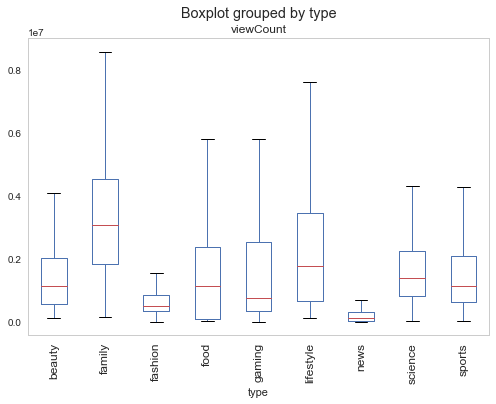

In [163]:
_=df.boxplot(column='viewCount', by='type', rot=90, grid=False, showfliers=False)

#### Detect viral videos (as measured with the Turkey method)
Use the Tukey method (Tukey JW., 1977) to detect ouliers which defines an interquartile range comprised between the 1st and 3rd quartile of the distribution values (IQR). An outlier is a row that have a feature value outside the (IQR +- an outlier step).

In [165]:
def detect_viral_vids(df, columns):
    
    outlier_indices = []
    
    for col in columns:
        Q1 = np.percentile(df[col],25)
        Q3 = np.percentile(df[col],75)
        IQR = Q3 - Q1

        step = 1.5 * IQR
        outlier_list_col = df[(df[col] < Q1 - step) | (df[col] > Q3 + step )].index
        outlier_indices.extend(outlier_list_col)

    outlier_indices = Counter(outlier_indices)        
    
    return outlier_indices

The  length of the dataframe is: 11509.000000
The  number of viral vids: 877.000000


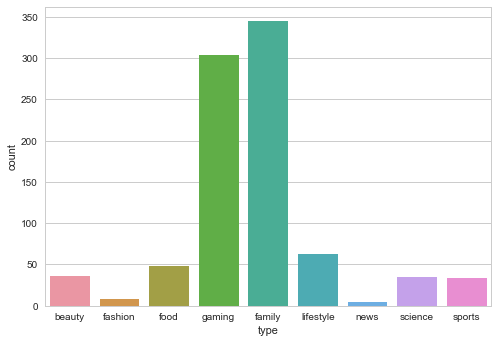

In [166]:
# Determine number of viral videos
viral_vids = detect_viral_vids(data,["viewCount"])
print('The  length of the dataframe is: %f' % len(data))
print('The  number of viral vids: %f' % len(viral_vids))

# View distribution of viral videos
subdata=data.loc[outliers_to_drop]
_=sns.countplot(x='type', data=subdata)

In [170]:
def detect_viral_vids_pertype(data, columns):
    
    outlier_indices = []
    
    datatypes= data.type.unique()
    
    for dftypes in datatypes:
        
        df=data[data['type']==dftypes]
    
        for col in columns:
            Q1 = np.percentile(df[col],25)
            Q3 = np.percentile(df[col],75)
            IQR = Q3 - Q1

            step = 1.5 * IQR
            outlier_list_col = df[(df[col] < Q1 - step) | (df[col] > Q3 + step )].index
            outlier_indices.extend(outlier_list_col)

    outlier_indices = Counter(outlier_indices)        
    
    return outlier_indices

The  length of the dataframe is: 11509.000000
The  number of viral vids: 1012.000000


commentCount  dislikeCount  favoriteCount  likeCount   viewCount     video_id          publishedAt  \
0             739.0         191.0              0    11178.0    274412.0  zfmi2JatvlY  2016-06-24 23:22:46   
1            1010.0         224.0              0    11737.0    319477.0  XlawoU0xCwQ  2016-06-23 02:46:20   
2            1230.0         284.0              0    27857.0    544192.0  mz2e0niwZhU  2016-06-19 21:14:21   
3            3064.0         191.0              0    19411.0    189773.0  PySIJJp4xuk  2016-05-24 02:21:09   
4             980.0         178.0              0    13184.0    306547.0  v2l5MygW8Wk  2016-05-21 20:30:09   
5            1756.0         473.0              0    24654.0    690936.0  9f7zmCSzG9E  2016-05-17 18:12:30   
6            2212.0         399.0              0    25805.0    710103.0  _WvINzTXpFE  2016-05-04 14:38:02   
7           11472.0         540.0              0    42420.0    994149.0  7E_oOCIkp-s  2016-04-23 17:44:44   
8            1940.0         678.0              0    31104.0    907481.0  CfOeL9Zlpn8  2016-04-13 06:39:36   
9            3801.0        1022.0              0    75187.0   2334867.0  Wxie1Oat5w4  2016-04-09 00:50:42   
10           1269.0         138.0              0    11725.0    246610.0  wWRq9FXStyE  2016-04-06 01:12:53   
11           2730.0         445.0              0    33605.0    859867.0  Sf8A7lUY6x8  2016-04-01 22:39:53   
12           1316.0         419.0              0    21977.0    541806.0  4flCLA8gogw  2016-03-25 20:39:30   
13           2001.0         495.0              0    19913.0    680097.0  g7RwkwvDaz0  2016-03-21 20:24:23   
14           2335.0         167.0              0    14094.0    270540.0  GW1kFzaMr2Y  2016-03-17 04:24:34   
15           3958.0         494.0              0    43050.0    948009.0  QMuHNginxNc  2016-03-05 06:42:31   
16           6107.0         476.0              0    27012.0    774223.0  xknZIK2s06k  2016-03-01 01:43:16   
17           2208.0         325.0              0    24406.0    542359.0  JHzqu9iBx0U  2016-02-19 02:23:10   
18           1412.0         106.0              0    12201.0    206715.0  Sgs0mEOrnt8  2016-02-12 11:23:31   
19           1722.0         707.0              0    54758.0   1514568.0  Lt3DWC5AznM  2016-02-07 03:05:10   
20           4537.0        3171.0              0    92289.0   4067638.0  K2pR7nTOnc0  2016-01-30 01:49:39   
21           2092.0         702.0              0    33522.0    766178.0  d3eQwNVucPg  2016-01-26 20:13:42   
22           6572.0        2128.0              0   128132.0   4008975.0  LJG7CQdd5_k  2016-01-15 22:50:09   
23           2676.0         695.0              0    33179.0    798092.0  rf3CgXEXRvQ  2016-01-09 04:47:43   
24          10619.0        1448.0              0    69986.0   1526405.0  -gYnmUv4j-s  2016-06-27 03:46:04   
25          11720.0        2022.0              0    73086.0   1668936.0  vWAsq-zJMJY  2016-06-22 03:18:18   
26           8521.0        1116.0              0    58731.0   1283978.0  vAYtyLZ8rsc  2016-06-15 00:21:14   
27           6837.0        1198.0              0    52406.0   1374523.0  MFRoyFcqzZ4  2016-06-06 01:16:57   
28          11742.0        1277.0              0    67206.0   1156467.0  rtG2Y0G-a8g  2016-05-21 01:19:10   
29          13850.0        2779.0              0   163647.0   5834817.0  XvH2ukztRzs  2016-05-16 00:15:38   
30           7879.0         497.0              0    30729.0   1749076.0  lTAChvJvMBA  2016-05-10 00:32:14   
31          11763.0        2343.0              0   121242.0   1988317.0  __7KZwQ0JlY  2016-05-06 00:57:33   
32          11393.0         893.0              0    77514.0    919347.0  7L2VOCwVem0  2016-05-02 02:42:58   
33           4805.0        1069.0              0    46290.0    919911.0  5Xu8l7nGW_Y  2016-04-24 23:05:26   
34           9032.0        1525.0              0    86892.0   3026694.0  QeR2qj0nxXQ  2016-04-18 01:43:38   
35           5367.0         970.0              0    43553.0    878952.0  KVq6byrDM0

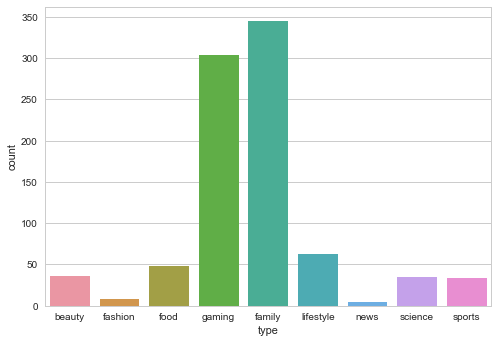

In [173]:
# Determine number of viral videos
viral_vids = detect_viral_vids_pertype(data,["viewCount"])
print('The  length of the dataframe is: %f' % len(data))
print('The  number of viral vids: %f' % len(viral_vids))

# View distribution of viral videos
subdata=data.loc[outliers_to_drop]
_=sns.countplot(x='type', data=subdata)

In [96]:
data.viewCount.describe()

count    1.150900e+04
mean     1.519543e+06
std      2.464771e+06
min      2.000000e+00
25%      1.556240e+05
50%      5.577120e+05
75%      1.982638e+06
max      8.146912e+07
Name: viewCount, dtype: float64

#### Variable: (Results)
- replaced NULL values with median
- family and lifestyle vidoes have the most views on average
- Avg viewCount is 1,500,000
- viral videos are most likely to be in gaming and family

# Step 3: Check indpendent variables

### Variable: type_of_day (weekday vs. weekend)

In [23]:
#check for null values
data.type_of_day.isnull().sum()

0

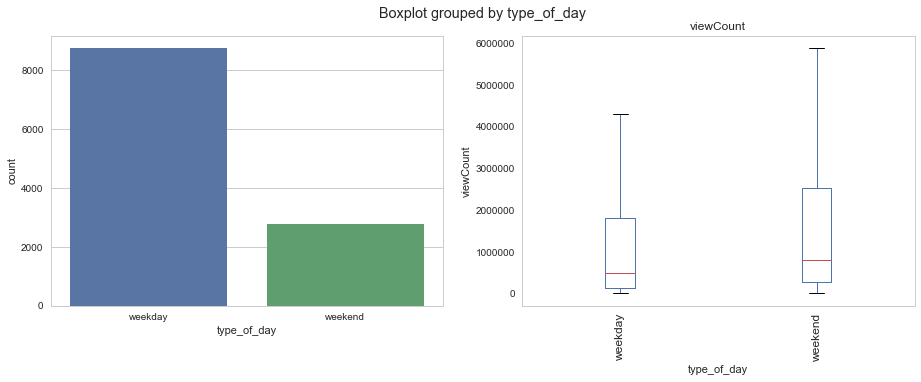

In [118]:
order=['weekday','weekend']
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,5))
_=sns.countplot(x='type_of_day', order=order, data=data, ax=axis1)
_=ax=df.boxplot(column='viewCount', by='type_of_day', rot=90, grid=False, showfliers=False, ax=axis2)
_=ax.set(xlabel="type_of_day", ylabel="viewCount")

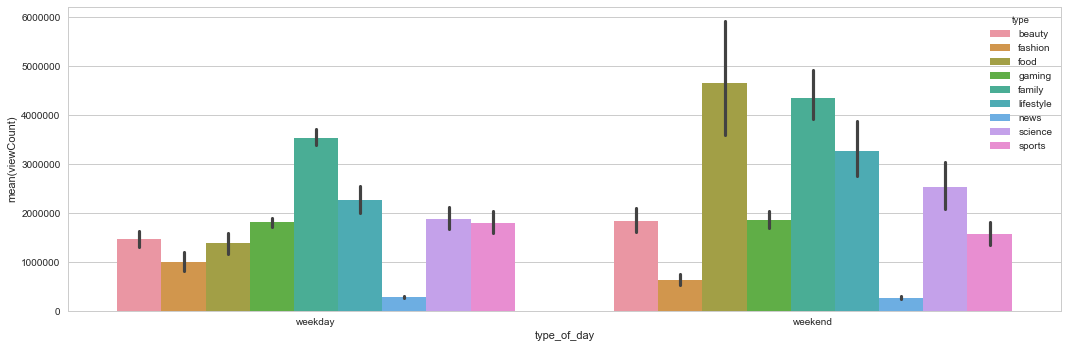

In [119]:
#plot average viewCount for type_of_day
fig, (axis1) = plt.subplots(1,1,figsize=(15,5))
_=sns.barplot(x='type_of_day', y='viewCount', order=order, hue='type', data=data, ax=axis1)
_=plt.xlabel('type_of_day')
_=plt.ylabel('mean(viewCount)')
plt.tight_layout()
plt.show()

#### Results for variable: type_of_day
- no NULL values
- More views for videos posted on weekends than on weekdays
- Difference between weekday and weekend may be driven by channel type as food videos get many more views when posted on weekend than on weekday! more people want to cook food on weekends?

### Variable: total_mins (duration of video in mins)

In [54]:
#check for null values
data.total_mins.isnull().sum()

0

In [55]:
data.total_mins.describe()

count    11509.000000
mean        12.529064
std         23.608806
min          0.000000
25%          3.000000
50%          8.000000
75%         14.000000
max        715.000000
Name: total_mins, dtype: float64

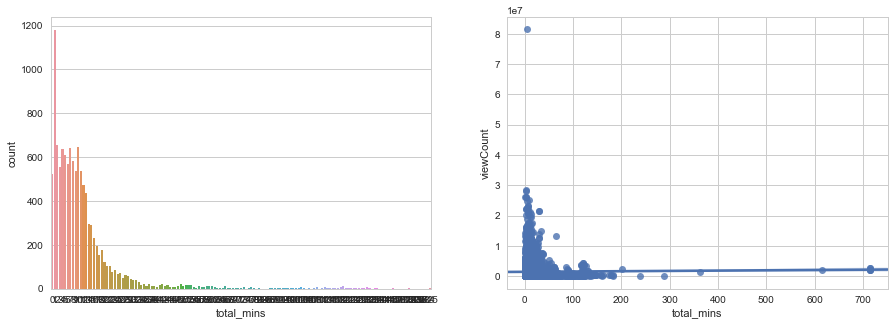

In [52]:
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,5))
_=sns.countplot(x='total_mins', data=data, ax=axis1)
_=sns.regplot(x='total_mins', y='viewCount', data=data, ax=axis2)

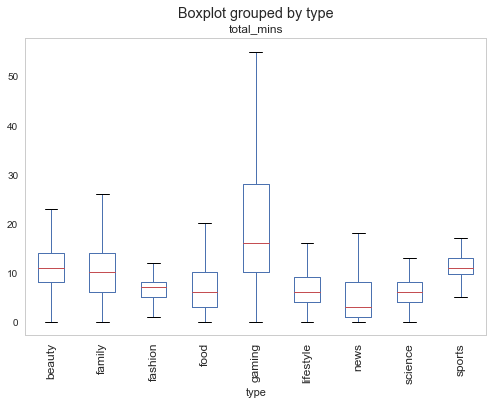

In [122]:
_=df.boxplot(column='total_mins', by='type', rot=90, grid=False, showfliers=False)

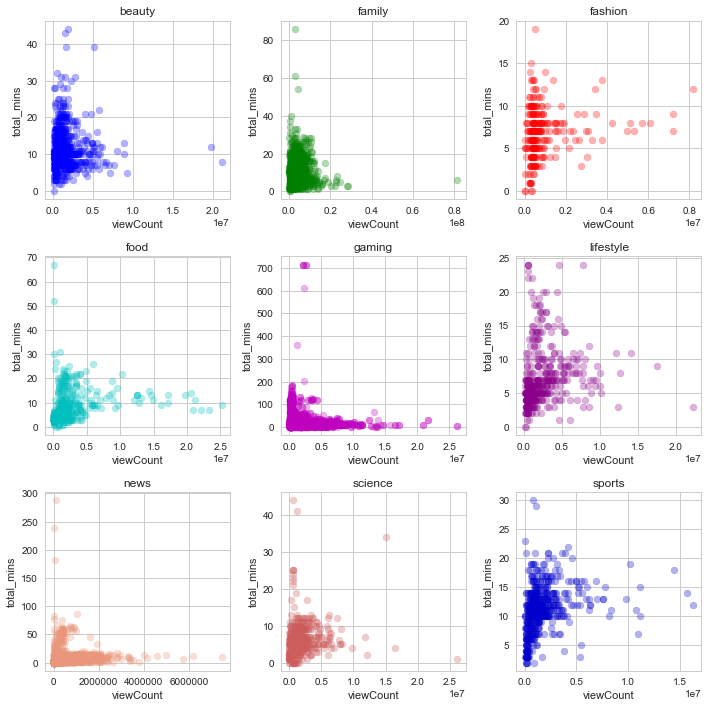

In [47]:
from pandas.tools import plotting
df=data
types=['beauty','family','fashion','food','gaming','lifestyle','news','science','sports']
columns=['viewCount', 'total_mins']
fig_xsize=10
fig_ysize=10

subdf=df[['viewCount','total_mins','type']]

fig_height=3
fig_width=3
fig=plt.figure(figsize=(fig_xsize, fig_ysize))
sub = fig.add_subplot(fig_height,fig_width,1)
i=0

for types, color in zip(types, ['b', 'g', 'r', 'c', 'm', '#8B008B', '#E9967A', '#CD5C5C', '#0000CD']):
    i=i+1
    tmp=subdf[subdf['type']==types]
    columnx=columns[0]
    columny=columns[1]
    _=xaxis=tmp[columnx]
    _=yaxis=tmp[columny]
    _=sub = fig.add_subplot(fig_height,fig_width,i)
    _=sub.set_xlabel(columnx)
    _=sub.set_ylabel(columny)
    _=sub.set_title(types)
    _=sub.scatter(xaxis,yaxis, color=color, alpha=0.3)
plt.tight_layout()

#### Results for variable: total_min
- no NULL values
- Wide range of total_mins but most videos are shorter (<14 mins)
- No relationship between total_mins and ViewCount but could this relationship be influenced by type of vid?
- Gaming videos have the longest videos
- No clear relationship between total_min and viewCount regardless of type

### Variable: type of video

In [97]:
#check for null values
data.type.isnull().sum()

0

In [99]:
data.type.describe()

count     11509
unique        9
top        news
freq       4159
Name: type, dtype: object

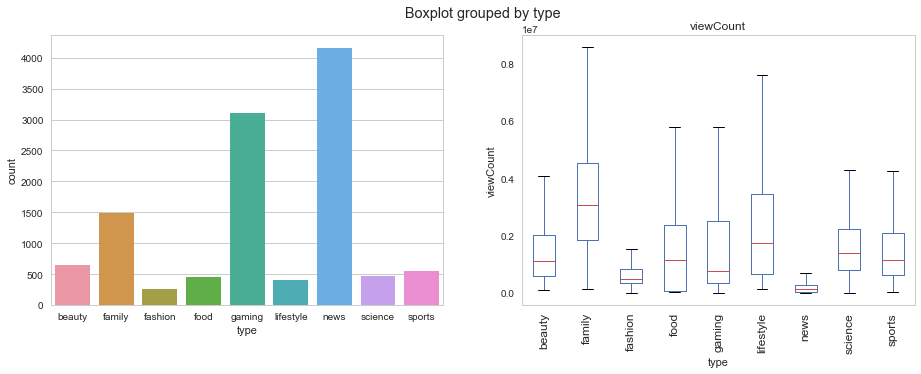

In [117]:
order=['beauty', 'family', 'fashion', 'food', 'gaming', 'lifestyle', 'news', 'science', 'sports']
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,5))
_=sns.countplot(x='type', data=data, order=order, ax=axis1)
_=ax=df.boxplot(column='viewCount', by='type', rot=90, grid=False, showfliers=False, ax=axis2)
_=ax.set(xlabel="type", ylabel="viewCount")

### Variable: vlog (vlog or not vlog)

In [130]:
#check for null values
data.vlog.isnull().sum()

0

In [137]:
data.vlog.describe()

count       11509
unique          2
top       notvlog
freq        11415
Name: vlog, dtype: object

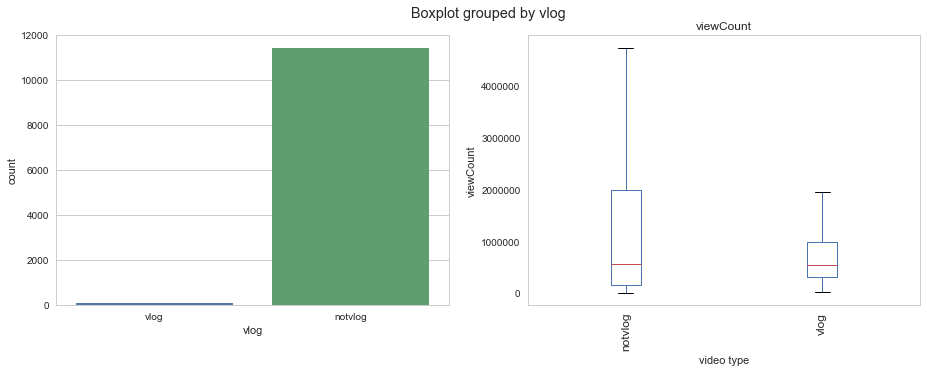

In [139]:
order=['vlog','notvlog']
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,5))
_=sns.countplot(x='vlog', order=order, data=data, ax=axis1)
_=ax=df.boxplot(column='viewCount', by='vlog', rot=90, grid=False, showfliers=False, ax=axis2)
_=ax.set(xlabel="video type", ylabel="viewCount")

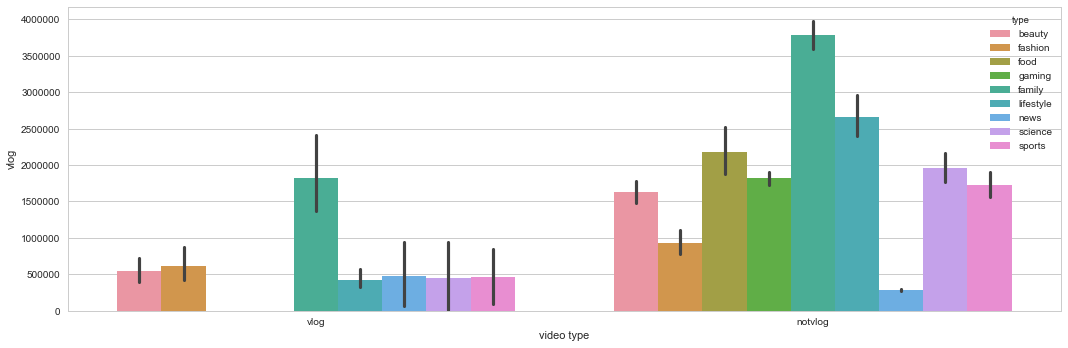

In [143]:
#plot average viewCount for type_of_day
fig, (axis1) = plt.subplots(1,1,figsize=(15,5))
_=sns.barplot(x='vlog', y='viewCount', order=order, hue='type', data=data, ax=axis1)
_=plt.xlabel('video type')
_=plt.ylabel('vlog')
plt.tight_layout()
plt.show()

#### Variable: vlog (Results)
- no NULL values
- most videos are not vlogs
- non-vlog vidoes have more views than vlogs
- family, fashion and news videos have a higher percentage of vlogs than other channel types

### Variable: title_length

In [145]:
#check for null values
data.title_length.isnull().sum()

0

In [147]:
data.title_length.describe()

count    11509.000000
mean        43.684508
std         16.582080
min          3.000000
25%         32.000000
50%         42.000000
75%         54.000000
max        100.000000
Name: title_length, dtype: float64

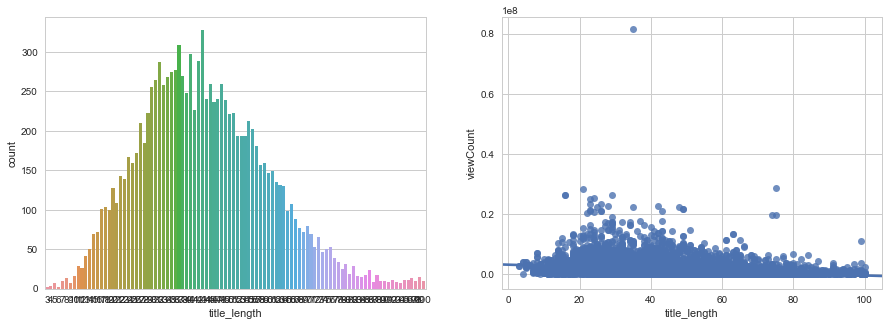

In [149]:
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,5))
_=sns.countplot(x='title_length', data=data, ax=axis1)
_=sns.regplot(x='title_length', y='viewCount', data=data, ax=axis2)

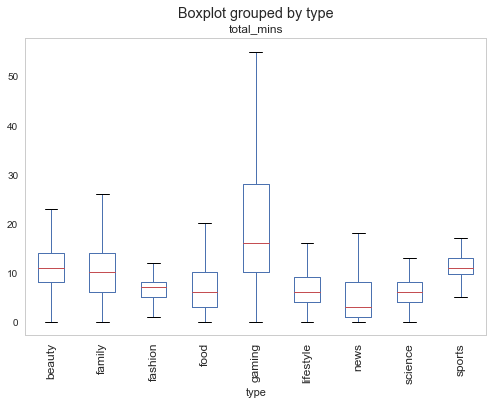

In [150]:
_=df.boxplot(column='total_mins', by='type', rot=90, grid=False, showfliers=False)

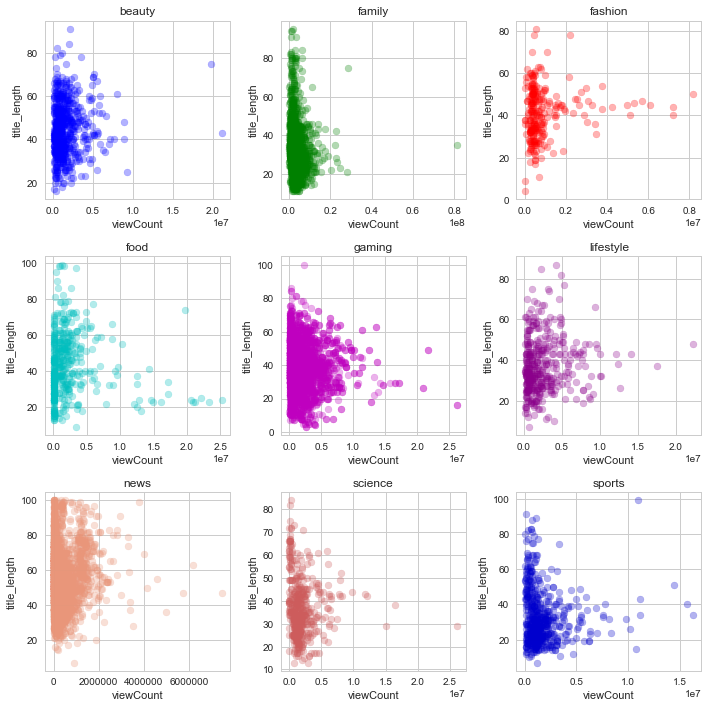

In [151]:
from pandas.tools import plotting
df=data
types=['beauty','family','fashion','food','gaming','lifestyle','news','science','sports']
columns=['viewCount', 'title_length']
fig_xsize=10
fig_ysize=10

subdf=df[['viewCount','title_length','type']]

fig_height=3
fig_width=3
fig=plt.figure(figsize=(fig_xsize, fig_ysize))
sub = fig.add_subplot(fig_height,fig_width,1)
i=0

for types, color in zip(types, ['b', 'g', 'r', 'c', 'm', '#8B008B', '#E9967A', '#CD5C5C', '#0000CD']):
    i=i+1
    tmp=subdf[subdf['type']==types]
    columnx=columns[0]
    columny=columns[1]
    _=xaxis=tmp[columnx]
    _=yaxis=tmp[columny]
    _=sub = fig.add_subplot(fig_height,fig_width,i)
    _=sub.set_xlabel(columnx)
    _=sub.set_ylabel(columny)
    _=sub.set_title(types)
    _=sub.scatter(xaxis,yaxis, color=color, alpha=0.3)
plt.tight_layout()

#### Variable: title_length (Results)
- no NULL values (indicates that all videos had a title)
- most videos had title range between 32-42 characters
- title_length was roughly normally distributed with a slight skew to the right
- gaming has, on average, the longest titles. other video types have roughly the same title_length
- no linear relationship between title length and viewCount
- may have a parabolic relationship between title_length and viewCount

### Variable: season

In [153]:
#check for null values
data.season.isnull().sum()

0

In [155]:
data.season.describe()

count      11509
unique         4
top       spring
freq        3107
Name: season, dtype: object

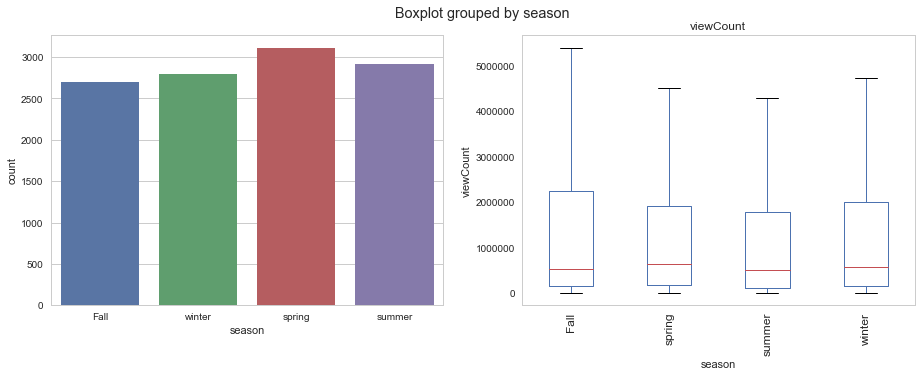

In [160]:
order=['Fall','winter', 'spring', 'summer']
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,5))
_=sns.countplot(x='season', order=order, data=data, ax=axis1)
_=ax=df.boxplot(column='viewCount', by='season', rot=90, grid=False, showfliers=False, ax=axis2)
_=ax.set(xlabel="season", ylabel="viewCount")

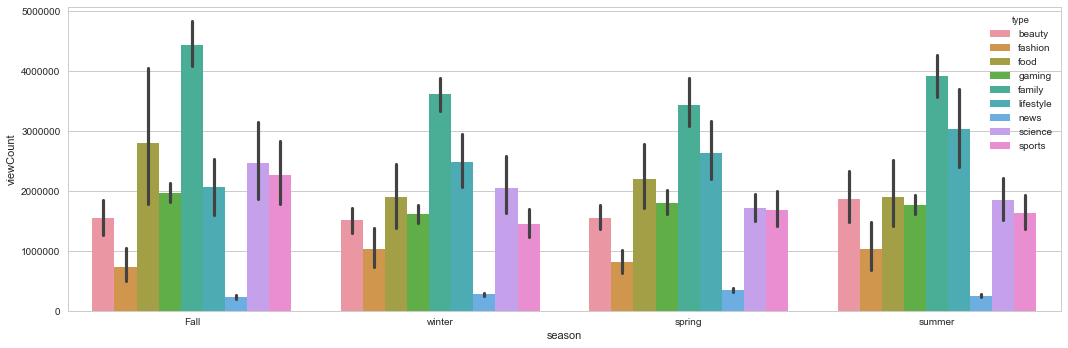

In [161]:
#plot average viewCount for type_of_day
fig, (axis1) = plt.subplots(1,1,figsize=(15,5))
_=sns.barplot(x='season', y='viewCount', order=order, hue='type', data=data, ax=axis1)
_=plt.xlabel('season')
_=plt.ylabel('viewCount')
plt.tight_layout()
plt.show()

#### Variable: season (Results)
- no NULL values
- most videos are posted in the spring, although mostly equal among all seasons
- variability in viewership is highest in the Fall
- no clear difference in video views between seasons except for family, food and sports where greatest viewership is in the fall

# Step 4: Determine which variables to use in final anlysis

Out of the tested variables, the following are likely to have a predictive role in determining viewCount
- type (gaming, family, ect.)
- type_of_day
- title_length
- season